# THIS FILE CONTAINS FIRST ITERATION OF EXPLORATION OF POTENTIAL VARIABLES AND MODEL 

## W O R K I N P R O G R E S S . . . .

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score

In [3]:
data = pd.read_csv('../Data/train.csv')
test_data = pd.read_csv('../Data/test.csv')

# 
    - Handle categorial 'parentspecies'

    - However we will see if there is any benefits as we do the feature selection

In [4]:
def drop_categorical(data):
    # driop the columns with too many missing values
    data = data.drop(columns=['parentspecies'])
    return data
data = drop_categorical(data)
test_data = drop_categorical(test_data)

# Correlation

In [ ]:
# Corr absoulte values
correlations = data.corr().abs()['log_pSat_Pa'].sort_values(ascending=False)
print(correlations)

In [ ]:
# corr viz
plt.figure(figsize=(16, 10))
sns.heatmap(data.corr().abs(), annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# Why not test this with test data

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 664
[LightGBM] [Info] Number of data points in the train set: 17047, number of used features: 23
[LightGBM] [Info] Start training from score -5.528850
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 663
[LightGBM] [Info] Number of data points in the train set: 17047, number of used features: 23
[LightGBM] [Info] Start training from score -5.519773
[LightGBM] [Warning] Found w

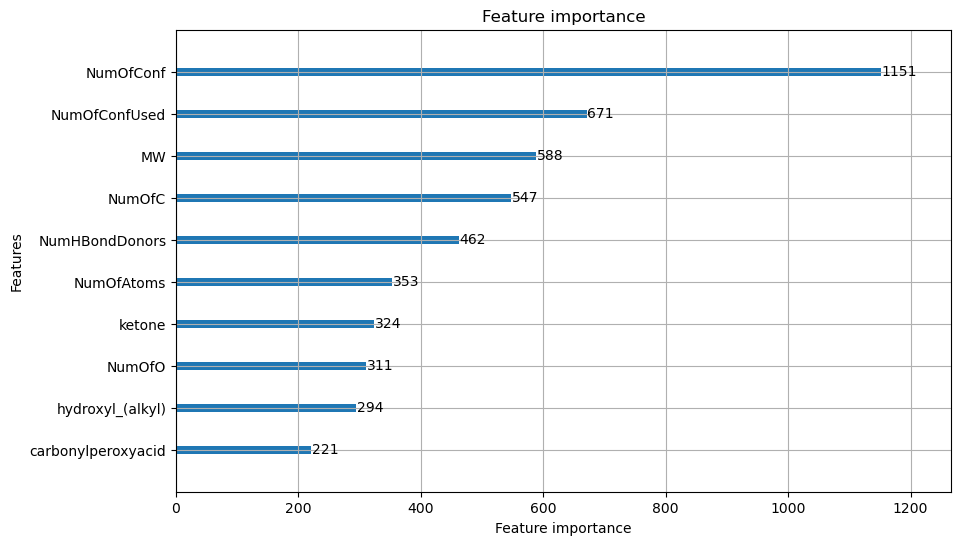

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.05, 'max_depth': 10, 'min_child_samples': 100, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': None, 'num_leaves': 14, 'objective': 'regression', 'random_state': 74, 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'metric': 'rmse'}


In [60]:
from sklearn.model_selection import RandomizedSearchCV

# Preprocessing
X = data.drop(columns=['log_pSat_Pa', 'ID'])

y = data['log_pSat_Pa']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=74)

# hyperparameter grid for optimization
param_grid = {
    "num_leaves": [14, 31, 50, 75],
    "max_depth": [3, 5, 7, 10, 15, -1],
    "learning_rate": [0.01, 0.04, 0.05, 0.1, 0.3], 
    "n_estimators": [100, 200, 500, 1000],
    "reg_alpha": [0, 0.1, 1], 
    "reg_lambda": [0, 0.1, 1],
    "min_child_samples": [20, 30, 50, 100],
}

# LGBM model
lgbm = lgb.LGBMRegressor(boosting_type='gbdt',
                         objective='regression',
                         metric='rmse',
                         random_state=74)

# GridSearchCV ( 3 folds cross-validation ) Change to random for faster results 
grid_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    return_train_score=True
    )

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print("Best :-) Hyperparameters:", best_params)


y_pred = best_model.predict(X_test)
rmse_test = mean_squared_error(y_test, y_pred) ** 0.5
print(f"RMSE on test set: {rmse_test}")
print(f'R2 Score on test set: {r2_score(y_test, y_pred)}')

# save the real test data predictions
test_data2 = test_data.copy()
test_data2 = test_data2.drop(columns=['ID'])
if 'TARGET' in test_data2.columns:
    test_data2 = test_data2.drop(columns=['TARGET'])
y_test_final_pred = best_model.predict(test_data2)
test_data['TARGET'] = y_test_final_pred
write_csv = test_data[['ID', 'TARGET']]
write_csv.to_csv('lgbm_cv_predictions.csv', index=False)

lgb.plot_importance(best_model, max_num_features=10, importance_type='split', figsize=(10,6))
plt.show()
print(best_model.get_params())


Best :-) Hyperparameters: {'reg_lambda': 1, 'reg_alpha': 0.1, 'num_leaves': 31, 'n_estimators': 500, 'min_child_samples': 30, 'max_depth': 10, 'learning_rate': 0.04}
RMSE on test set: 1.5855703961476684
Best :-) Hyperparameters: {'reg_lambda': 0.1, 'reg_alpha': 0.1, 'num_leaves': 50, 'n_estimators': 200, 'min_child_samples': 20, 'max_depth': 15, 'learning_rate': 0.05}


--

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.04, 'max_depth': 10, 'min_child_samples': 30, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': None, 'num_leaves': 31, 'objective': 'regression', 'random_state': 15, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'metric': 'rmse'}

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.05, 'max_depth': 15, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 200, 'n_jobs': None, 'num_leaves': 50, 'objective': 'regression', 'random_state': 74, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'metric': 'rmse'}


# Lets try faster training with less tuning with native lgbm no gridsearch / rndm search

/home/saavajuu/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:738: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003912 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 664
[LightGBM] [Info] Number of data points in the train set: 17044, number of used features: 23
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 664
[LightGBM] [Info] Number of data points in the train set: 17044, number of used features: 23
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wi

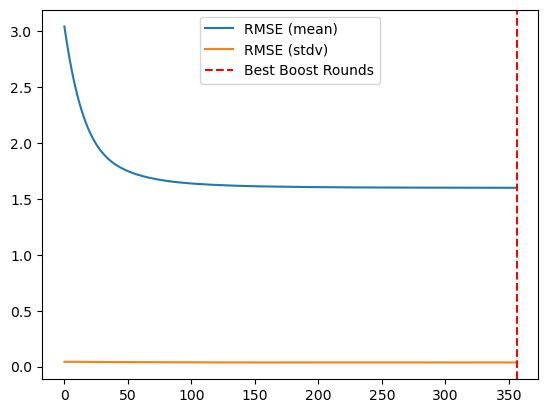

/home/saavajuu/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002388 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 664
[LightGBM] [Info] Number of data points in the train set: 21309, number of used features: 23
[LightGBM] [Info] Start training from score -5.531698
Training until validation scores don't improve for 75 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

In [53]:
# lest tune and train lgbm with cv and early stop without grid search
X = data.drop(columns=['log_pSat_Pa', 'ID'])

y = data['log_pSat_Pa']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=74)

# LGBM model
parameters = {
    "num_leaves": 41,
    "max_depth": 7,
    "learning_rate": 0.04,
    "num_boost_round": 700,
    "min_gain_to_split": 0.05,
    "reg_alpha": 0.1,
    "reg_lambda": 0.1,
    "subsample": 0.9,
    "boosting_type": 'gbdt',
    "objective": 'regression',
    "metric": 'rmse',
    "random_state": 74
}

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

cv_results = lgb.cv(
    params=parameters,
    train_set=lgb_train,
    nfold=5,
    metrics="rmse",
    stratified=False,
    callbacks=[lgb.early_stopping(stopping_rounds=75)],
    seed=74
)

best_num_boost_round = len(cv_results['valid rmse-mean'])
print(f"Best number of boosting rounds: {best_num_boost_round}")

# adjust the number of boosting rounds
parameters["num_boost_round"] = best_num_boost_round

plt.plot(cv_results['valid rmse-mean'], label='RMSE (mean)')
plt.plot(cv_results['valid rmse-stdv'], label='RMSE (stdv)')
plt.axvline(best_num_boost_round, color='red', linestyle='--', label='Best Boost Rounds')
plt.legend()
plt.show()

model = lgb.train(parameters,
                  lgb_train,
                  valid_sets=[lgb_eval],
                  callbacks=[lgb.early_stopping(stopping_rounds=75)])

y_pred = model.predict(X_test)
rmse_test = mean_squared_error(y_test, y_pred) ** 0.5
print(f"RMSE on test set: {rmse_test}")
print(f"R2 Score on test set: {r2_score(y_test, y_pred)}")

# save and do the predictions for test data
test_data2 = test_data.copy()
test_data2 = test_data2.drop(columns=['ID'])
if 'TARGET' in test_data2.columns:
    test_data2 = test_data2.drop(columns=['TARGET'])
y_test_final_pred = model.predict(test_data2)
test_data['TARGET'] = y_test_final_pred
write_csv = test_data[['ID', 'TARGET']]
write_csv.to_csv('lgbm_nat_predictions.csv', index=False)
